## Визуализация векторов

In [1]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from umap import UMAP
from langdetect import detect
from textblob import TextBlob

2024-05-24 19:08:32.803238: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 19:08:33.363882: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 19:08:33.368757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 19:08:34.930318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv('df_res2_modified.csv')

/tmp/ipykernel_149/3360911203.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('df_res2_modified.csv')


In [3]:
model = KeyedVectors.load_word2vec_format('cc.en.300.vec.gz', binary=False, limit=50000)

In [4]:
model.vector_size

300

In [5]:
vocab_size = len(model.key_to_index)
print("Размер словаря:", vocab_size)

Размер словаря: 50000


In [6]:
def vectorize_text(text):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0)    

Применяю doc2vec, чтобы каждый документ был отдельным вектором

In [7]:
tagged_data = [TaggedDocument(words=str(text).split(), tags=[check]) for text, check in zip(data['abstract'], data['check'])]
doc2vec_model = Doc2Vec(tagged_data, vector_size=300, window=5, min_count=1, workers=4, epochs=10)

In [8]:
def detect_lang(text):
    if pd.isnull(text):
        return "unknown"
    else:
        try:
            b = detect(str(text))
            return b
        except:
            return 'nolang'

Создаю колонку, где буду сохранять язык аннотации

In [9]:
data['language'] = data['abstract'].apply(detect_lang)
data['language_check']= [0 if lang == 'en' else 1 for lang in data['language']]

In [15]:
vectors = []
for doc in tagged_data:
    if doc.words:
        vector = doc2vec_model.infer_vector(doc.words)
    else:
        vector = np.zeros(doc2vec_model.vector_size)  # Создание нулевого вектора
    vectors.append(vector)

vectors = np.array(vectors)
labels = data['language_check'].values

In [ ]:
#vectors = np.array([doc2vec_model.infer_vector(doc.words) for doc in tagged_data])

Снижаю размерность через umap

In [16]:
umap = UMAP(n_components=2, unique = False)
vectors_2d = umap.fit_transform(vectors)

In [17]:
len(vectors_2d)

254579

Визуализирую, выделяя черным аннотации, не входящие в рамки размера (201-999 знаков), а желтым - все остальные

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


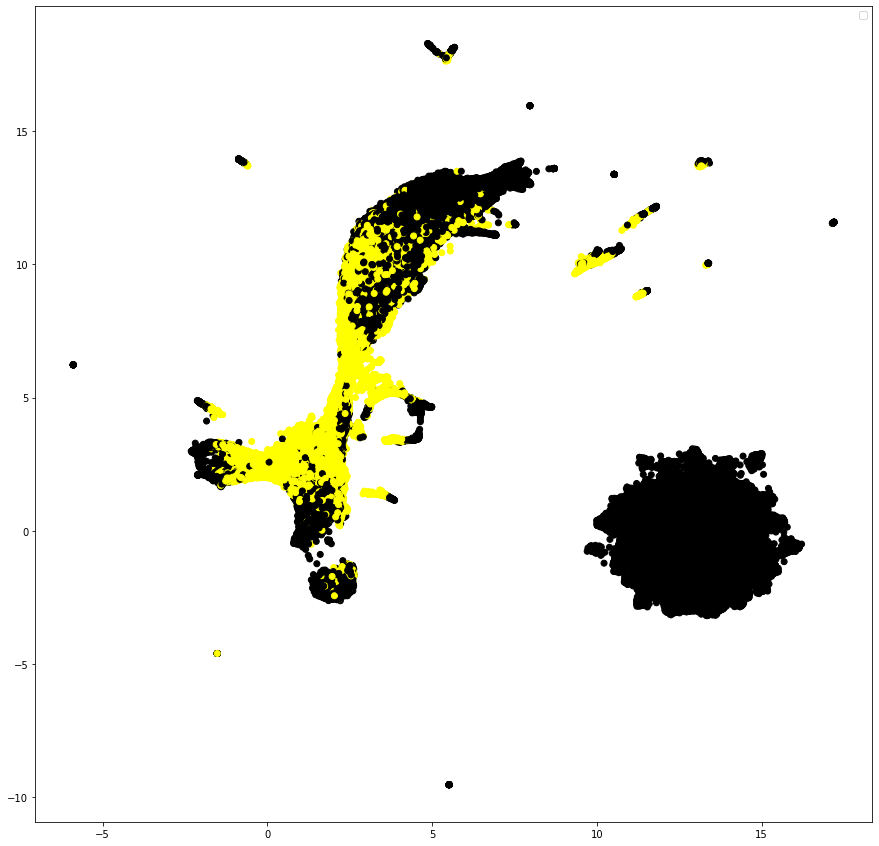

In [18]:
figure1 = plt.figure(figsize=(15, 15))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=['yellow' if len(str(x)) >= 201 and len(str(x)) <= 999 else 'black' for x in data['abstract']])
plt.legend()
#plt.show()

In [19]:
figure1.savefig('big_small.jpg', dpi=300)

In [20]:
data['language'][:50]

0     unknown
1     unknown
2     unknown
3     unknown
4     unknown
5     unknown
6     unknown
7     unknown
8     unknown
9     unknown
10    unknown
11    unknown
12    unknown
13    unknown
14    unknown
15    unknown
16    unknown
17    unknown
18         en
19         en
20         en
21         en
22         en
23         en
24         en
25         en
26         en
27         en
28         en
29         en
30         en
31         en
32         en
33         en
34         en
35         en
36         en
37         en
38         en
39         en
40         en
41         en
42         en
43         en
44         en
45         en
46         en
47         en
48         en
49         en
Name: language, dtype: object

Голубым - аннотации на английском языке

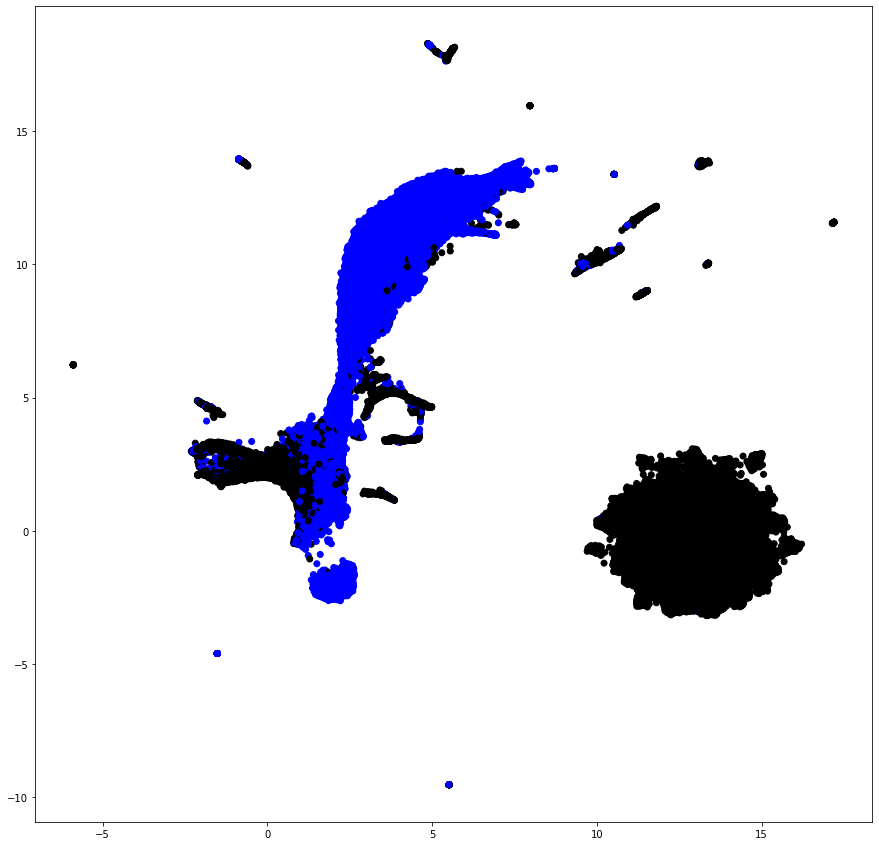

In [22]:
figure2 = plt.figure(figsize=(15, 15))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=['blue' if lang == 'en' else 'black' for lang in data['language']])

In [23]:
figure2.savefig('english_else.jpg', dpi=300)

Розовым - аннотации на французском языке

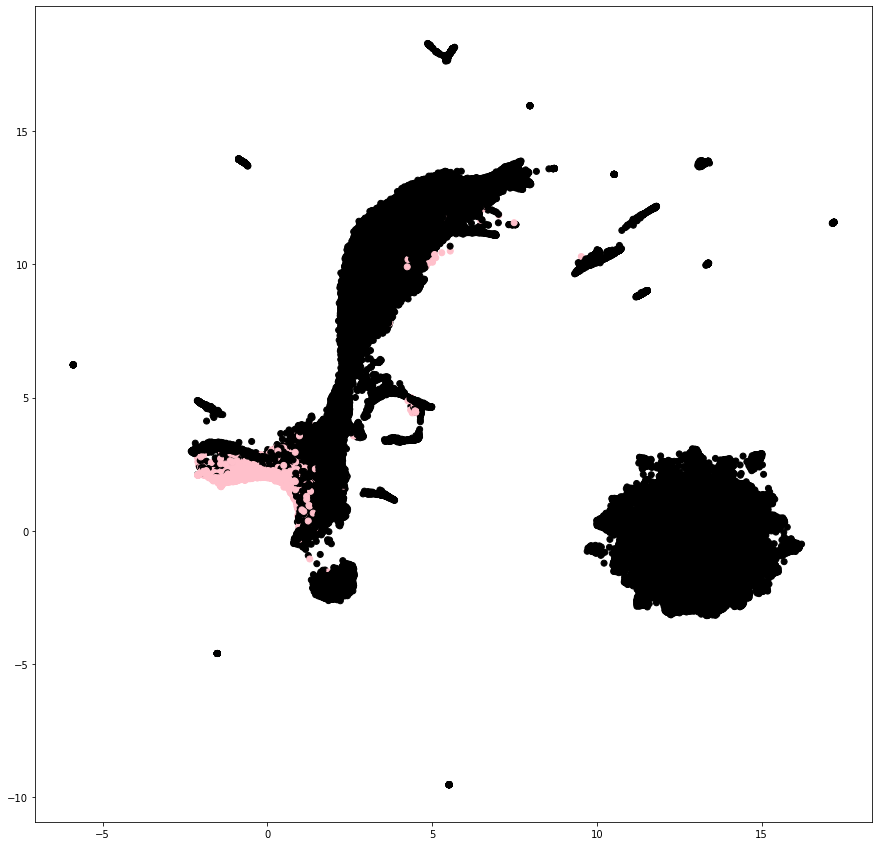

In [25]:
figure3 = plt.figure(figsize=(15, 15))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=['pink' if lang == 'fr' else 'black' for lang in data['language']])

In [26]:
figure3.savefig('french_else.jpg', dpi=300)

Фиолетовым - аннотации на немецком языке

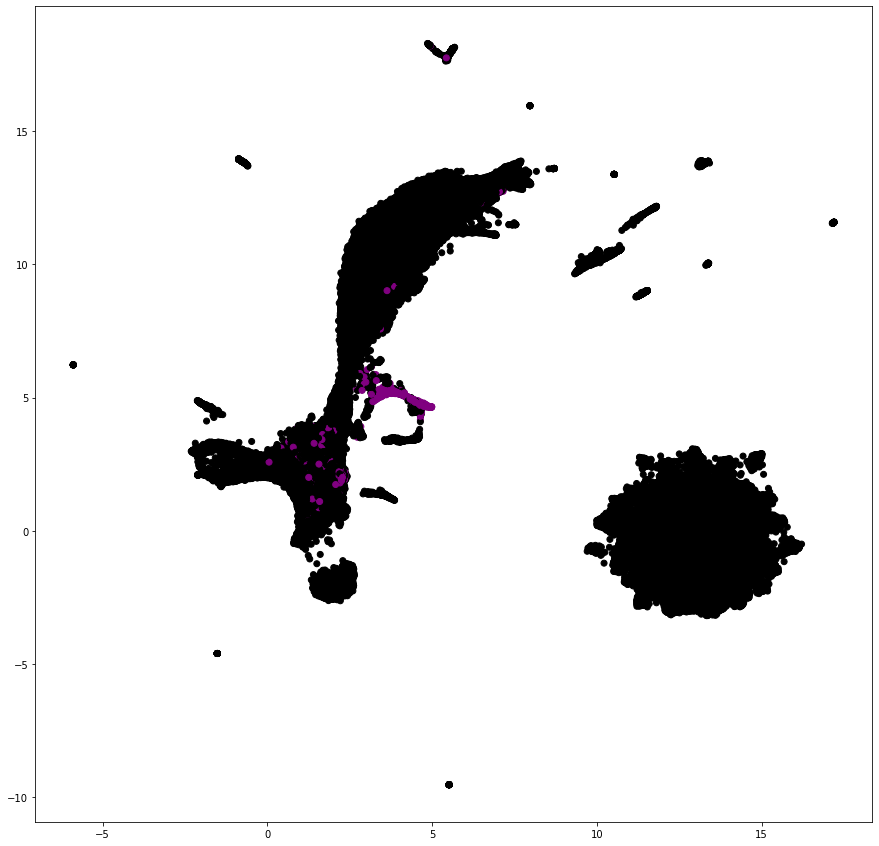

In [28]:
figure4 = plt.figure(figsize=(15, 15))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=['purple' if lang == 'de' else 'black' for lang in data['language']])

In [29]:
figure4.savefig('german_else.jpg', dpi=300)

Красным - аннотации на русском языке

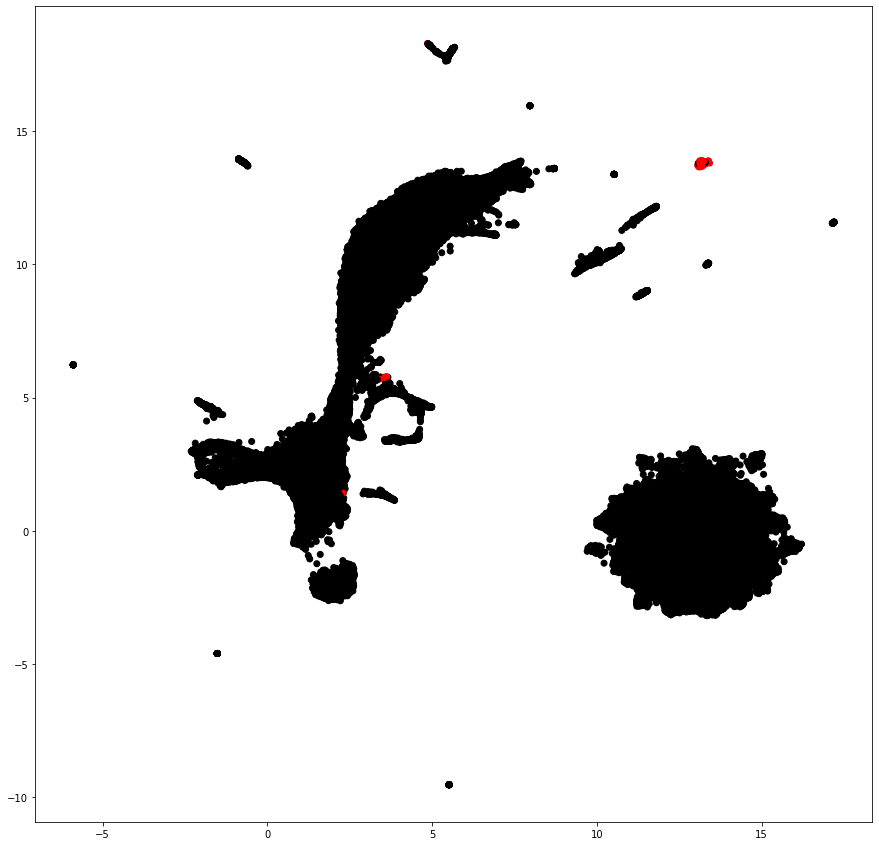

In [31]:
figure5 = plt.figure(figsize=(15, 15))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=['red' if lang == 'ru' else 'black' for lang in data['language']])

In [32]:
figure5.savefig('russian_else.jpg', dpi=300)

Оранжевым - аннотации, у которых определить язык оказалось невозможным

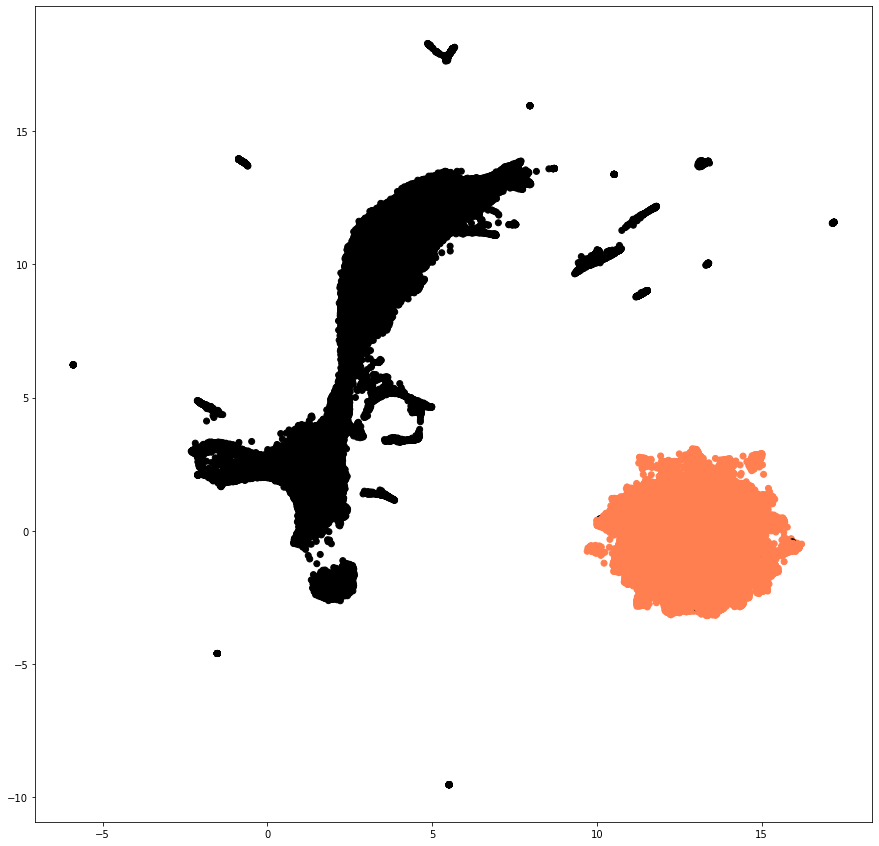

In [34]:
figure6 = plt.figure(figsize=(15, 15))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=['coral' if lang == 'unknown' else 'black' for lang in data['language']])

In [35]:
figure6.savefig('unknown_else.jpg', dpi=300)

Красным - аннотации, требующие удаления, синим - аннотации, которые показались модели приемлемыми

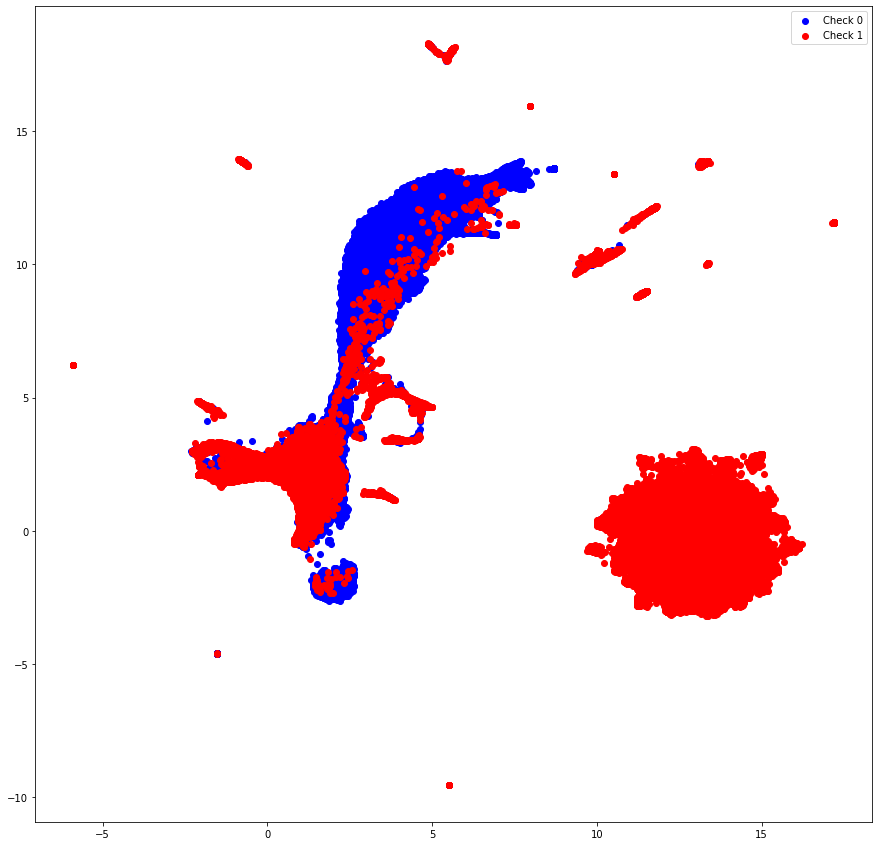

In [45]:
figure7 = plt.figure(figsize=(15, 15))
plt.scatter(vectors_2d[labels == 0, 0], vectors_2d[labels == 0, 1], c='blue', label='Check 0')
plt.scatter(vectors_2d[labels == 1, 0], vectors_2d[labels == 1, 1], c='red', label='Check 1')
plt.legend()

In [42]:
figure7.savefig('delete_normal.jpg', dpi=300)

In [43]:
count_zeros = (data['check'] == 0).sum()
count_ones = (data['check'] == 1).sum()

print("Количество нулей:", count_zeros)
print("Количество единиц:", count_ones)


Количество нулей: 83283
Количество единиц: 171296


Просто попытка визуализировать вектора по-другому, через sklearn

In [12]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(SimpleImputer(strategy="constant"), QuantileTransformer())
X = pipe.fit_transform(vectors)

In [13]:

manifold = UMAP(n_components=2).fit(X)
X_reduced_2 = manifold.transform(X)

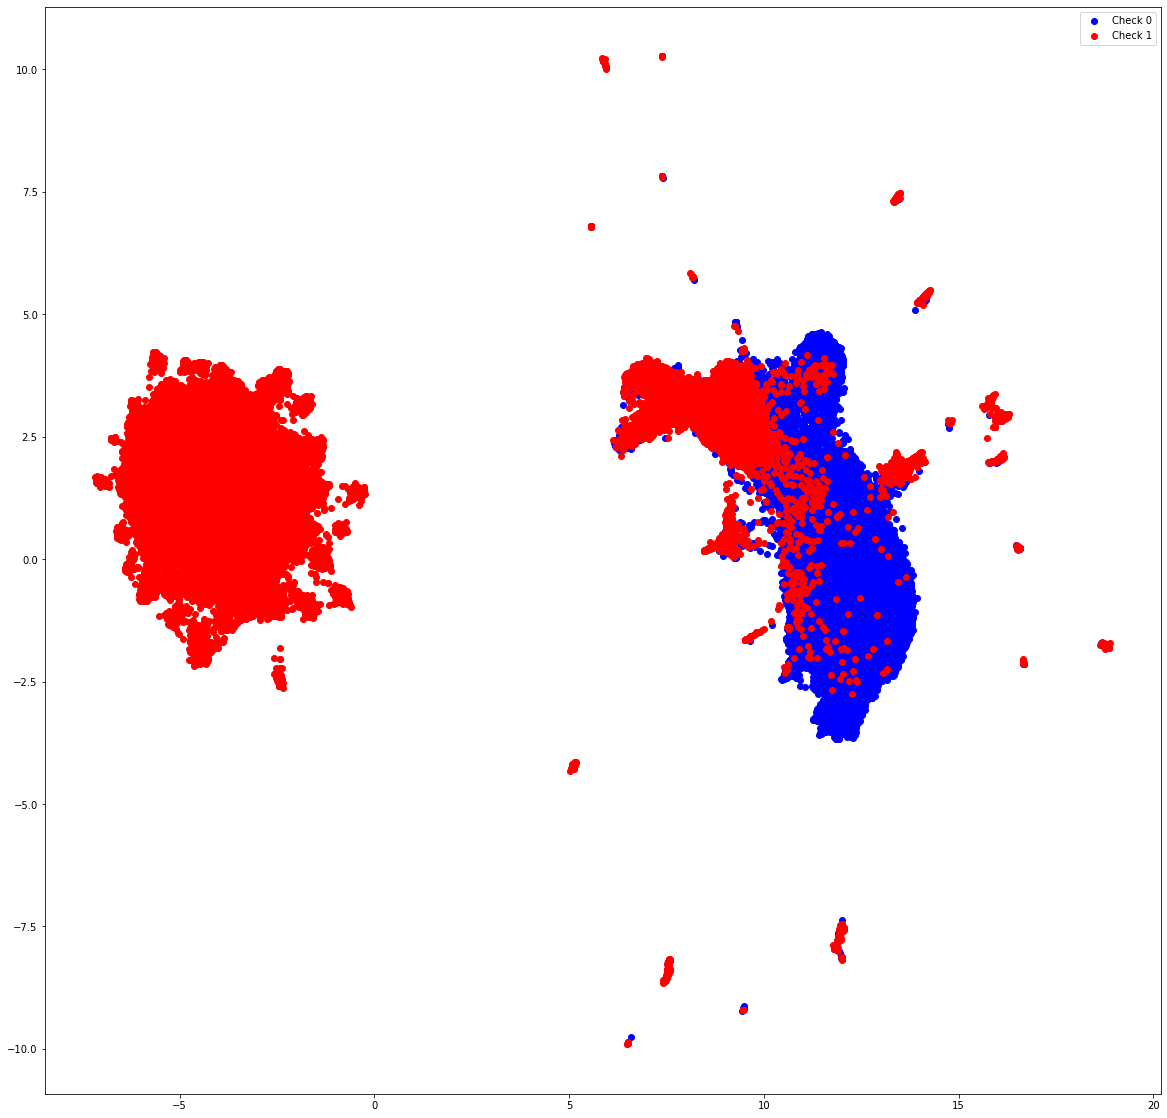

In [14]:
plt.figure(figsize=(20, 20))
plt.scatter(X_reduced_2[labels == 0, 0], X_reduced_2[labels == 0, 1], c='blue', label='Check 0')
plt.scatter(X_reduced_2[labels == 1, 0], X_reduced_2[labels == 1, 1], c='red', label='Check 1')
plt.legend()
plt.show()